In [1]:
import torch
import torchvision.models as models
from torch import nn
from PIL import Image
vgg16_pretrained = models.vgg16(pretrained=False)

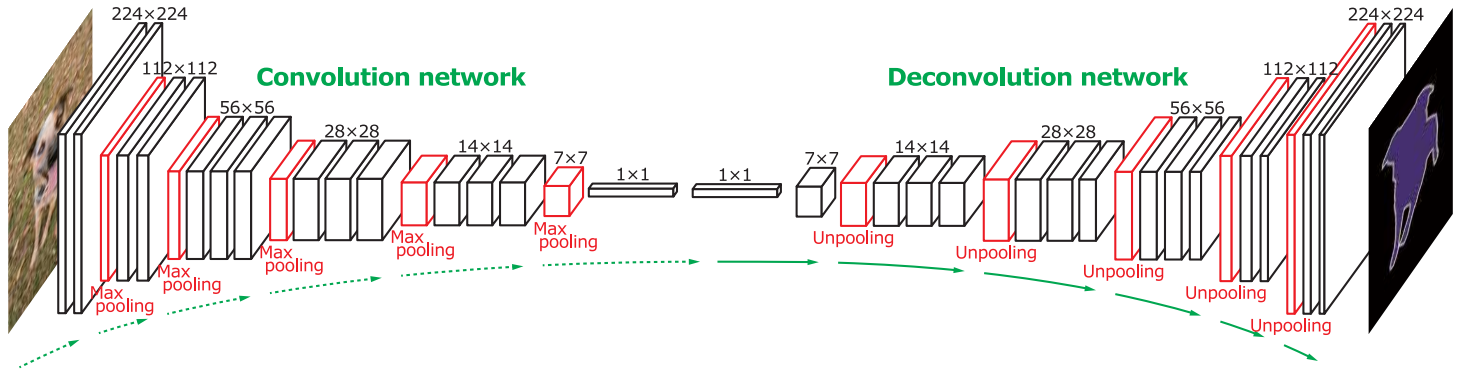

In [4]:
Image.open('/home/lsj/Music/2.png')

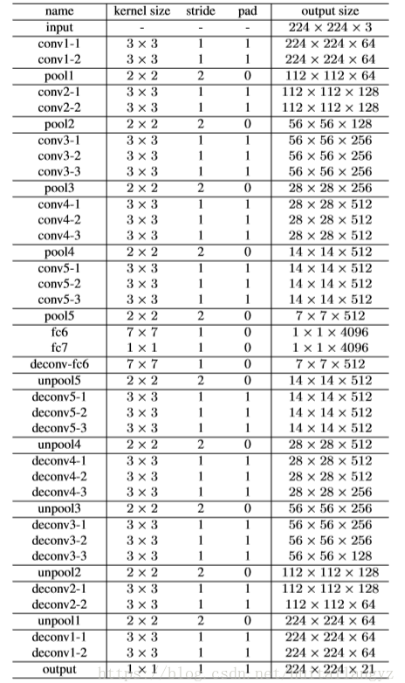

In [5]:
Image.open('/home/lsj/Music/3.png')

In [6]:
def decoder(input_channel, output_channel, num=3):
    if num == 3:
        decoder_body = nn.Sequential(
            nn.ConvTranspose2d(input_channel, input_channel, 3, padding=1),
            nn.ConvTranspose2d(input_channel, input_channel, 3, padding=1),
            nn.ConvTranspose2d(input_channel, output_channel, 3, padding=1))
    elif num == 2:
        decoder_body = nn.Sequential(
            nn.ConvTranspose2d(input_channel, input_channel, 3, padding=1),
            nn.ConvTranspose2d(input_channel, output_channel, 3, padding=1))

    return decoder_body

In [12]:
class VGG16_DeconvNet(torch.nn.Module):
    def __init__(self):
        super(VGG16_DeconvNet, self).__init__()

        pool_list = [4, 9, 16, 23, 30]
        for index in pool_list:
            vgg16_pretrained.features[index].return_indices = True

        self.encoder1 = vgg16_pretrained.features[:4]
        self.pool1 = vgg16_pretrained.features[4]

        self.encoder2 = vgg16_pretrained.features[5:9]
        self.pool2 = vgg16_pretrained.features[9]

        self.encoder3 = vgg16_pretrained.features[10:16]
        self.pool3 = vgg16_pretrained.features[16]

        self.encoder4 = vgg16_pretrained.features[17:23]
        self.pool4 = vgg16_pretrained.features[23]

        self.encoder5 = vgg16_pretrained.features[24:30]
        self.pool5 = vgg16_pretrained.features[30]

        self.classifier = nn.Sequential(
            torch.nn.Linear(512 * 11 * 15, 4096),
            torch.nn.ReLU(),
            torch.nn.Linear(4096, 512 * 11 * 15),
            torch.nn.ReLU(),
        )

        self.decoder5 = decoder(512, 512)
        self.unpool5 = nn.MaxUnpool2d(2, 2)

        self.decoder4 = decoder(512, 256)
        self.unpool4 = nn.MaxUnpool2d(2, 2)

        self.decoder3 = decoder(256, 128)
        self.unpool3 = nn.MaxUnpool2d(2, 2)

        self.decoder2 = decoder(128, 64, 2)
        self.unpool2 = nn.MaxUnpool2d(2, 2)

        self.decoder1 = decoder(64, 12, 2)
        self.unpool1 = nn.MaxUnpool2d(2, 2)

    def forward(self, x):                       
        encoder1 = self.encoder1(x)
        output_size1 = encoder1.size()          
        pool1, indices1 = self.pool1(encoder1) 

        encoder2 = self.encoder2(pool1)       
        output_size2 = encoder2.size()         
        pool2, indices2 = self.pool2(encoder2)

        encoder3 = self.encoder3(pool2)     
        output_size3 = encoder3.size()        
        pool3, indices3 = self.pool3(encoder3)  

        encoder4 = self.encoder4(pool3)        
        output_size4 = encoder4.size()  
        pool4, indices4 = self.pool4(encoder4) 

        encoder5 = self.encoder5(pool4)        
        output_size5 = encoder5.size()          
        pool5, indices5 = self.pool5(encoder5) 

        pool5 = pool5.view(pool5.size(0), -1);print('pool5:', pool5.size())
        fc = self.classifier(pool5);print('fc:', fc.size())
        fc = fc.reshape(1, 512, 11, 15);print('fc:', fc.size())

        unpool5 = self.unpool5(input=fc, indices=indices5, output_size=output_size5)   
        decoder5 = self.decoder5(unpool5)   

        unpool4 = self.unpool4(input=decoder5, indices=indices4, output_size=output_size4) 
        decoder4 = self.decoder4(unpool4)   

        unpool3 = self.unpool3(input=decoder4, indices=indices3, output_size=output_size3)  
        decoder3 = self.decoder3(unpool3)  

        unpool2 = self.unpool2(input=decoder3, indices=indices2, output_size=output_size2) 
        decoder2 = self.decoder2(unpool2)  

        unpool1 = self.unpool1(input=decoder2, indices=indices1, output_size=output_size1) 
        decoder1 = self.decoder1(unpool1)  
        
        return decoder1

In [13]:
image = torch.rand((1, 3, 352, 480))
image.size()

torch.Size([1, 3, 352, 480])

In [14]:
DeconvNet = VGG16_DeconvNet()

In [15]:
mask = DeconvNet(image)

pool5: torch.Size([1, 84480])
fc: torch.Size([1, 84480])
fc: torch.Size([1, 512, 11, 15])
